In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from functools import partial

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [173]:

def n_loose_btag(t):
    nL = 1*t.ak4_h1b1_btag_L + 1*t.ak4_h1b2_btag_L + 1*t.ak4_h2b1_btag_L + 1*t.ak4_h2b2_btag_L
    return ak.values_astype(nL, np.int32)
def n_medium_btag(t):
    nM = 1*t.ak4_h1b1_btag_M + 1*t.ak4_h1b2_btag_M + 1*t.ak4_h2b1_btag_M + 1*t.ak4_h2b2_btag_M
    return ak.values_astype(nM, np.int32)

In [25]:

treekwargs = dict(
    weights=['xsecWeight/1000','genWeight','puWeight'],
    treename='Events',
    normalization=None,
)

base = fc.fs.cernbox.fullpath(f'/eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L')

f_pattern = '{base}/mc/ggHH4b_tree.root'
f_sig = f_pattern.format(base=base)

f_pattern = '{base}/mc/qcd-mg_tree.root'
f_qcd = f_pattern.format(base=base)

In [87]:
signal = ObjIter([Tree(f_sig, **treekwargs)])
bkg = ObjIter([Tree(f_qcd, **treekwargs)])

  0%|          | 0/1 [00:00<?, ?it/s]

Using local path: /cmsuf/data/store/user/ekoenig/root/eosuser.cern.ch/eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L/mc/ggHH4b_tree.root


  0%|          | 0/1 [00:00<?, ?it/s]

Using local path: /cmsuf/data/store/user/ekoenig/root/eosuser.cern.ch/eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L/mc/qcd-mg_tree.root


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


In [88]:
class h_dm(ObjTransform):
    def __init__(self, signal : ObjIter, range=(75, 175)):
        scale = signal.scale.cat
        h1_regmass = signal.dHH_H1_regmass.cat
        h2_regmass = signal.dHH_H2_regmass.cat

        h1_mask = (h1_regmass > range[0]) & (h1_regmass < range[1])
        self.h1_mean = int(ak.mean(h1_regmass[h1_mask], scale[h1_mask]))

        h2_mask = (h2_regmass > range[0]) & (h2_regmass < range[1])
        self.h2_mean = int(ak.mean(h2_regmass[h2_mask], scale[h2_mask]))

    @property
    def xlabel(self):
        return f'$\Delta M_{{H}}({self.h1_mean}, {self.h2_mean})$'

    @property
    def bins(self): return (0,100,30)

    def __call__(self, t):
        return np.sqrt( (t.dHH_H1_regmass - self.h1_mean)**2 + (t.dHH_H2_regmass - self.h2_mean)**2 )

In [168]:
mindiag_h_dm = h_dm(signal)

(signal + bkg).apply(lambda t : t.extend(h_dm = mindiag_h_dm(t)))

[None, None]

100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


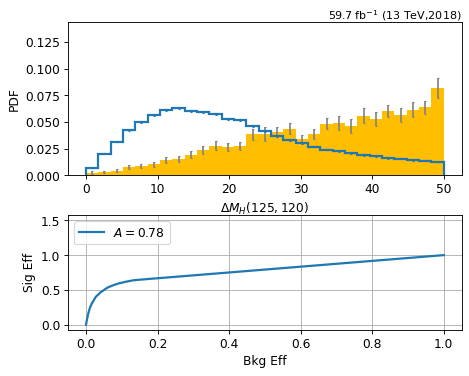

In [90]:
study.quick(
    signal+bkg,
    varlist=[mindiag_h_dm],
    binlist=[(0,50,30)],
    efficiency=True,
    **study.auroc,
)

In [134]:
feynnet_signal = signal.apply(lambda t : t.copy(sample=f'FeynNet {t.sample}'))
feynnet_bkg = bkg.apply(lambda t : t.copy(sample=f'FeynNet {t.sample}'))

In [172]:
# modelpath = '/home/ekoenig/analysis/weaver-multiH/models/feynnet_lightning/nanoHH4b/sixjet/training-data-scan/lightning_logs/version_11881857'
modelpath = '/home/ekoenig/analysis/weaver-multiH/models/feynnet_lightning/nanoHH4b/sixjet/lightning_logs/version_12177187/'

load_feynnet = fourb.nanohh4b.f_evaluate_feynnet(modelpath)

(feynnet_signal + feynnet_bkg).apply(load_feynnet)

predicting: 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


[None, None]

In [174]:
(signal+feynnet_signal).apply(fourb.nanohh4b.match_ak4_gen)

[None, None]

100%|██████████| 2/2 [00:00<00:00, 20.35it/s]


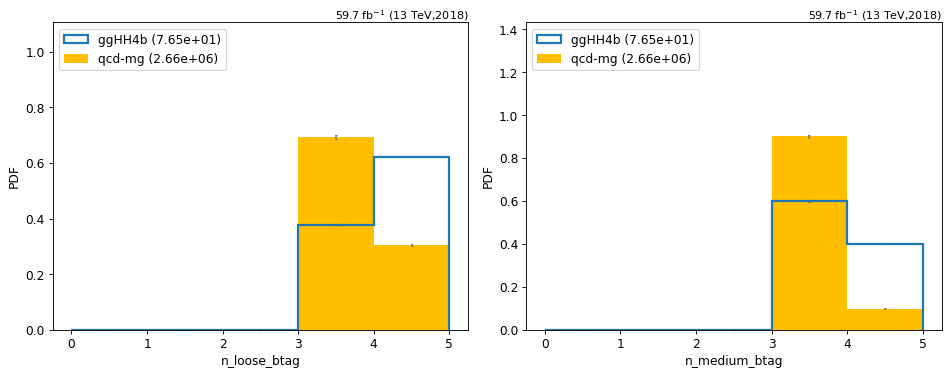

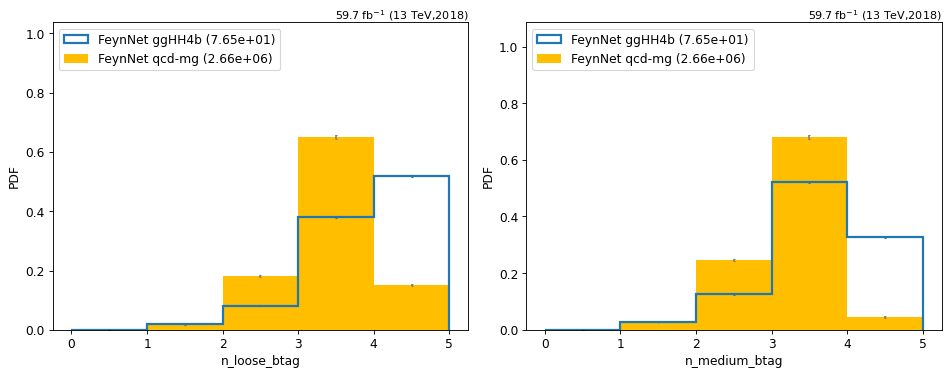

In [178]:
study.quick(
    signal + bkg,
    # masks=lambda t : t.nfound_select==4,
    # masks=lambda t : n_loose_btag(t) == 4,

    varlist=[n_loose_btag, n_medium_btag],
    legend=True,
    efficiency=True,
)
study.quick(
    feynnet_signal + feynnet_bkg,
    # masks=lambda t : t.nfound_select==4,
    # masks=lambda t : n_loose_btag(t) == 4,

    varlist=[n_loose_btag, n_medium_btag],
    legend=True,
    efficiency=True,
)

100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


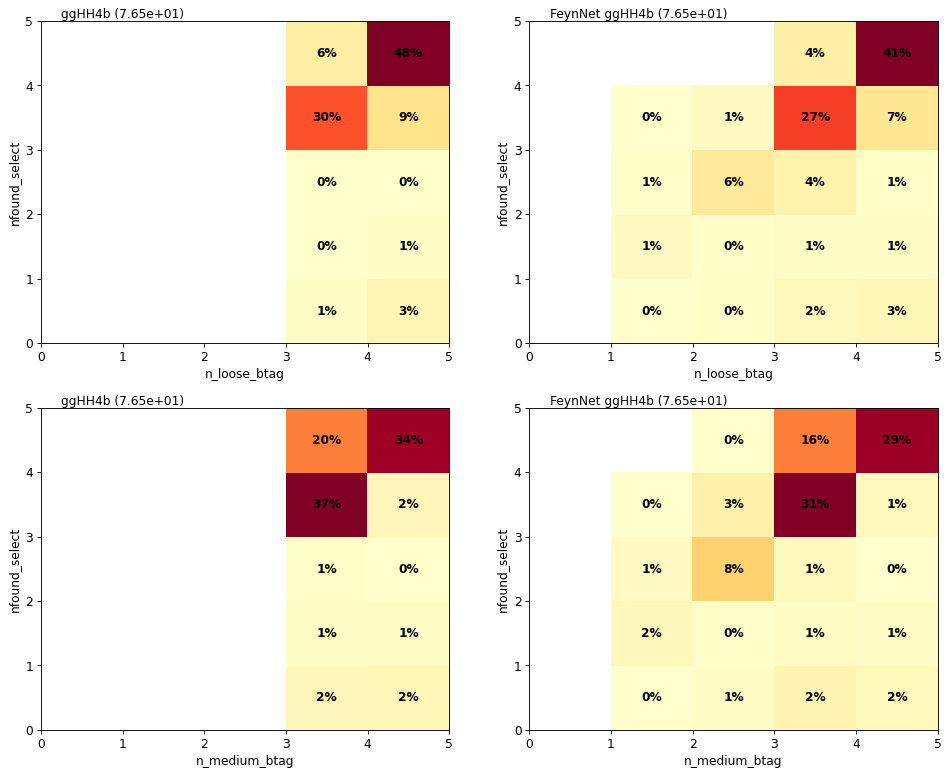

In [183]:
study.quick2d(
    signal + feynnet_signal,
    xvarlist=[n_loose_btag, n_medium_btag],
    yvarlist=['nfound_select']*2,
    legend=True,
    efficiency=True,
    show_counts=lambda n : f'{n:.0%}',
)

100%|██████████| 2/2 [00:00<00:00, 36.01it/s]


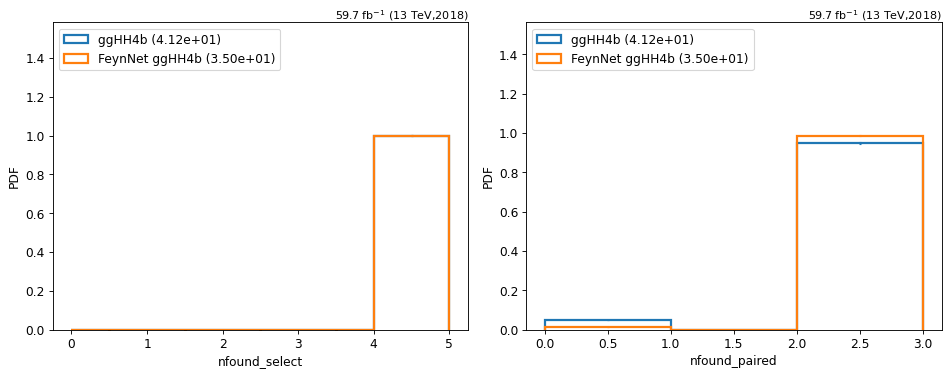

In [186]:
study.quick(
    signal + feynnet_signal,
    masks=lambda t : t.nfound_select==4,
    # masks=lambda t : n_loose_btag(t) == 4,

    varlist=['nfound_select','nfound_paired'],
    legend=True,
    efficiency=True,
)

In [187]:
feynnet_h_dm = h_dm(feynnet_signal)
(feynnet_signal + feynnet_bkg).apply(lambda t : t.extend(h_dm = feynnet_h_dm(t)))

[None, None]

100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


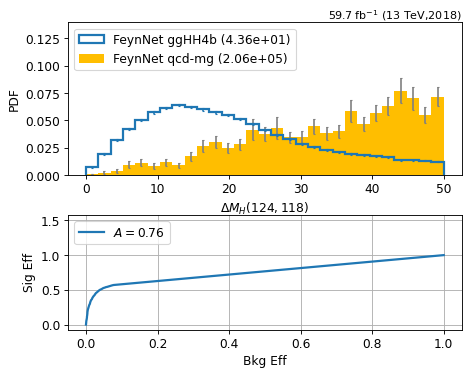

In [188]:
study.quick(
    feynnet_signal+feynnet_bkg,
    varlist=[feynnet_h_dm],
    binlist=[(0,50,30)],
    efficiency=True,
    legend=True,
    **study.auroc,
)

100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


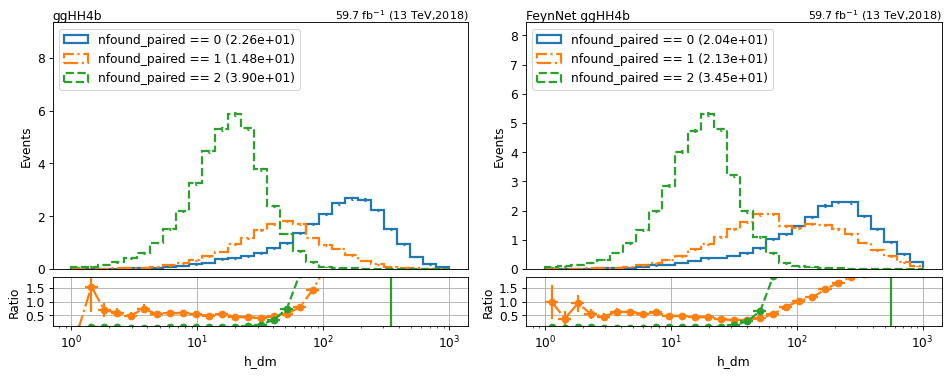

In [189]:
study.compare_masks(
    signal+feynnet_signal,
    masks=['nfound_paired == 0','nfound_paired == 1', 'nfound_paired == 2'],
    legend=True,
    varlist=['h_dm'],
    binlist=[np.logspace(0, 3, 30)],
    logx=True,
    ratio=True,
)

100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


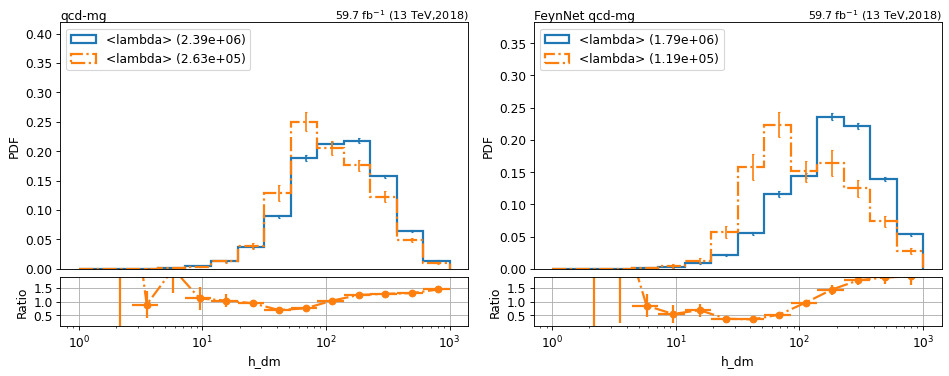

In [190]:
study.compare_masks(
    bkg+feynnet_bkg, stacked=False,
    h_color=None,
    masks=[lambda t : n_medium_btag(t) == 3,lambda t : n_medium_btag(t) == 4],
    legend=True,
    varlist=['h_dm'],
    binlist=[np.logspace(0, 3, 15)],
    logx=True,
    ratio=True,
    efficiency=True,
)

100%|██████████| 2/2 [00:00<00:00, 12.22it/s]


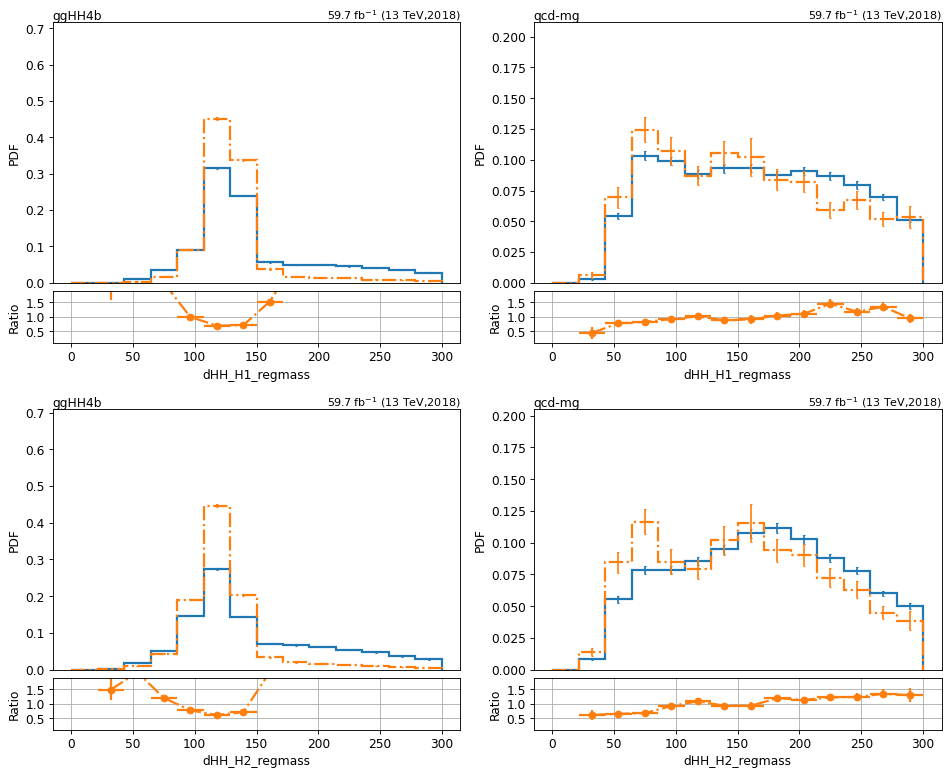

In [197]:
study.compare_masks(
    signal+bkg, stacked=False,
    h_color=None, efficiency=True,
    masks=[lambda t : n_medium_btag(t) == 3,lambda t : n_medium_btag(t) == 4],
    varlist=['dHH_H1_regmass','dHH_H2_regmass'],
    binlist=[(0,300,15)]*2,
    ratio=True
)

100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


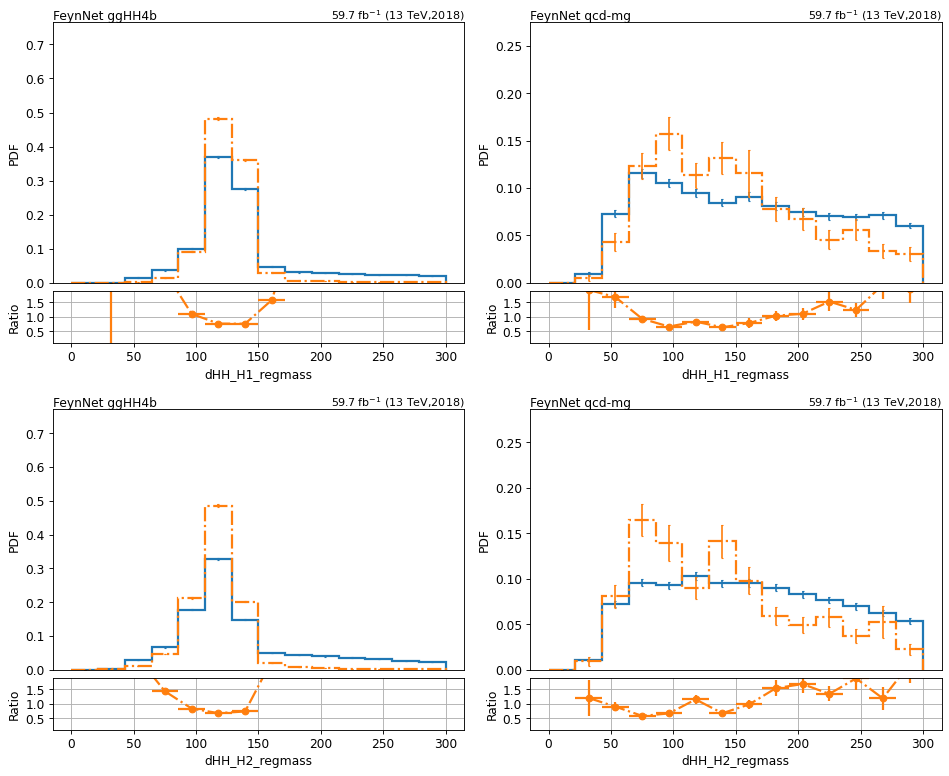

In [198]:
study.compare_masks(
    feynnet_signal+feynnet_bkg, stacked=False,
    h_color=None, efficiency=True,
    masks=[lambda t : n_medium_btag(t) == 3,lambda t : n_medium_btag(t) == 4],
    varlist=['dHH_H1_regmass','dHH_H2_regmass'],
    binlist=[(0,300,15)]*2,
    ratio=True
)